In [31]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn import datasets, linear_model, metrics
import _pickle as pickle
import time
import seaborn as sns
from xgboost import XGBRegressor as xgb

In [2]:
import math
import numpy as np
import h5py
from matplotlib.pyplot import imread
import scipy
from sklearn.decomposition import PCA
import pandas as pd
import tensorflow as tf
import tensorflow.python.keras.layers as tfl
import tensorflow.python.keras.backend as K
#from cnn_utils import *
#from test_utils import summary, comparator
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tensorflow.keras import regularizers
from sklearn.neighbors import KNeighborsRegressor
#%matplotlib inline

In [3]:
with open("dataa", "rb") as input_file:
   df = pickle.load(input_file)

In [4]:
len(df)

6792

## data preprocessing

Data from SPIES & SHELA are equivalent, so we merge them

In [6]:
df['CH2']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH2_SHELA'].iloc[i]!=-99 :
        if df['CH2_SPIES'].iloc[i]!=-99 :
            df['CH2'].iloc[i]=(df['CH2_SPIES'].iloc[i]+df['CH2_SHELA'].iloc[i])/2
        else :
            df['CH2'].iloc[i]=df['CH2_SHELA'].iloc[i]
    elif df['CH2_SPIES'].iloc[i]!=-99 :
        df['CH2'].iloc[i]=df['CH2_SPIES'].iloc[i]
df['CH1']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH1_SHELA'].iloc[i]!=-99 :
        if df['CH1_SPIES'].iloc[i]!=-99 :
            df['CH1'].iloc[i]=(df['CH1_SPIES'].iloc[i]+df['CH1_SHELA'].iloc[i])/2
        else :
            df['CH1'].iloc[i]=df['CH1_SHELA'].iloc[i]
    elif df['CH1_SPIES'].iloc[i]!=-99 :
        df['CH1'].iloc[i]=df['CH1_SPIES'].iloc[i]
    else :
        df['CH1'].iloc[i]=np.nan

C:\Users\Dheeru\Anaconda3\envs\vk\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
dff=df[['U','G','R','I','Z','J','H','K','W1','W2','CH1','CH2','REDSHIFT','SDSS_REL_CLASS','VHS_REL_CLASS','IRAC_REL_CLASS']].replace(-99,np.nan)
dff=dff.dropna(subset=['REDSHIFT'])
dff=dff.dropna(thresh=len(dff.columns)-2)
dff[['SDSS_REL_CLASS','VHS_REL_CLASS','IRAC_REL_CLASS']]=dff[['SDSS_REL_CLASS','VHS_REL_CLASS','IRAC_REL_CLASS']].replace(b'N/A          ',np.nan)
dff=dff.dropna(subset=['SDSS_REL_CLASS','VHS_REL_CLASS','IRAC_REL_CLASS'])
dff=dff.drop(columns=['SDSS_REL_CLASS','VHS_REL_CLASS','IRAC_REL_CLASS'])

In [8]:
dff=dff[dff['REDSHIFT'] > 0]

In [9]:
dff=dff.dropna(subset=['U','G','R','I','Z','J','H','K','CH1','CH2','REDSHIFT'])
Xc=['U','G','R','I','Z','J','H','K','CH1','CH2']

In [10]:
len(dff) #number of samples without missing features (except W1 & W2 fluxes)

1925

In [11]:
dff.describe()

,U,G,R,I,Z,J,H,K,W1,W2,CH1,CH2,REDSHIFT
count,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1680.000000,1680.000000,1925.000000,1925.000000,1925.000000
mean,21.079748,20.438478,19.944450,19.627502,19.403372,19.215797,19.011116,18.794092,18.407362,18.231125,18.374897,18.228232,1.005965
std,1.544234,1.490225,1.484761,1.476073,1.477082,1.354198,1.361445,1.326727,1.120105,1.075143,1.195906,1.128162,0.708942
min,14.763513,13.166665,12.418087,12.020036,11.712891,12.789773,12.552818,12.608815,12.625000,13.084000,11.783983,12.279943,0.000003
25%,20.232285,19.739395,19.254524,18.978558,18.764835,18.574793,18.366615,18.118448,17.882750,17.699251,17.856613,17.689665,0.430516
50%,21.090353,20.564707,20.160135,19.883675,19.704405,19.477678,19.300751,19.068735,18.570999,18.345001,18.543217,18.384651,0.870000
75%,22.018427,21.374174,20.859304,20.583105,20.363676,20.149681,19.972250,19.733696,19.185499,18.986000,19.178196,18.993513,1.429999
max,28.536663,24.199265,23.246281,22.638111,22.463102,24.643478,22.869122,21.628582,20.705000,20.584999,21.099796,21.067528,5.391201


<IPython.core.display.Javascript object>


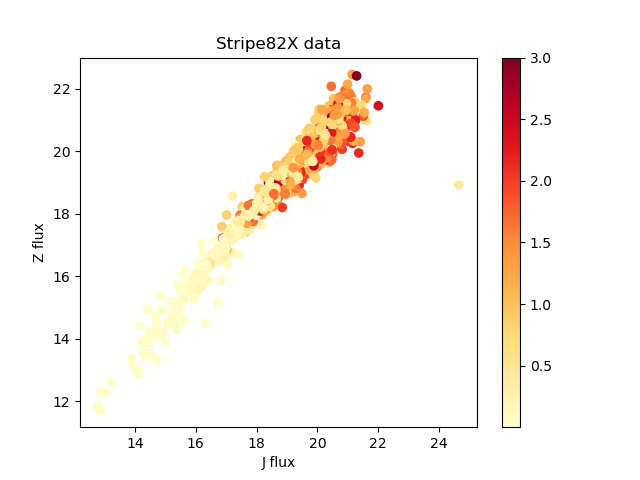

Text(0.5, 1.0, 'Stripe82X data')

In [12]:
plt.figure()
plt.scatter(dff['J'],dff['Z'],c=dff['REDSHIFT'],cmap='YlOrRd',vmax=3)
plt.colorbar()
plt.xlabel('J flux')
plt.ylabel('Z flux')
plt.title('Stripe82X data')

## predict missing values

We use a xgboost model to predict the missing W1 & W2 fluxes using other known fluxes

In [13]:
#FOR SKIPPING
#dff=dff.dropna()

In [13]:
dffp=dff.copy()

In [14]:
dff['miss']=np.isnan(dff['W1'])

In [15]:
dfftrain=dff.where(dff['miss']==False).dropna(subset=['REDSHIFT'])

In [16]:
dfftest=dff.where(dff['miss']==True).dropna(subset=['REDSHIFT'])

In [17]:
len(dfftest)

245

In [18]:
cols=['W1','W2']
for i in range(2):
    col=cols[i]
    X_train,y_train=dfftrain.drop(columns=[*cols,'miss']),dfftrain[col]
    knn=xgb()
    knn.fit(np.array(X_train),np.array(y_train))
    dfftest[col]=knn.predict(dfftest[['U','G','R','I','Z','J','H','K','CH1','CH2','REDSHIFT']])

In [19]:
dff=dfftrain.merge(dfftest,how='outer').drop(columns=['miss'])

In [20]:
len(dff)

1925

In [21]:
dff  #A view of our dataset

,U,G,R,I,Z,J,H,K,W1,W2,CH1,CH2,REDSHIFT
0,21.213541,20.620443,19.989361,19.716251,19.409750,18.962244,18.743366,18.432032,17.678999,17.138000,17.464193,17.076193,1.057000
1,20.541595,20.385698,20.250439,20.271524,20.166700,19.725740,19.933990,19.408987,18.799000,18.451000,18.808151,18.720428,0.914107
2,20.844740,20.210665,19.405510,18.990084,18.555473,18.425730,18.178875,17.858994,17.827999,17.687000,17.794222,17.544395,0.352113
3,23.159597,21.888151,21.535547,21.586559,21.216776,20.508423,20.293821,20.165888,19.923000,19.136000,19.730434,19.528378,1.040000
4,21.252272,21.144905,20.871641,20.872396,20.408800,20.048107,19.778837,19.619225,18.841000,18.646999,18.730791,18.691008,1.031814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,22.623421,21.654957,20.175081,19.387457,19.076351,19.252111,18.963631,18.563677,18.497622,18.784903,18.520473,18.844166,0.478814
1921,21.168139,20.846973,20.679424,20.253860,20.020334,19.721155,19.300751,18.895920,18.374409,17.983458,18.238554,17.983294,0.517168
1922,23.773195,21.462437,21.184237,21.067150,21.081985,20.460365,20.578161,20.619713,20.425756,19.641119,20.672134,20.258337,3.091000
1923,19.038204,17.469166,16.671171,16.237946,15.938605,16.235264,15.992501,16.020039,16.199793,16.620577,16.002110,16.341866,0.095407


## training & prediction

### SVR

In [73]:
'''dfg=dfg.sample(frac=1)
X_data,y_data=dfg[['PCA1','PCA2']],dfg['redshift']'''

"dfg=dfg.sample(frac=1)\nX_data,y_data=dfg[['PCA1','PCA2']],dfg['redshift']"

In [110]:
dfg=dfg.sample(frac=1)
X_data,y_data=dfg[range(12)],dfg['redshift']

In [111]:
dff=dff.sample(frac=1)
X_data,y_data=dff[Xc],dff['REDSHIFT']

In [112]:
scaler = StandardScaler()
Xs_data=scaler.fit_transform(X_data)

In [113]:
def score(ys_data,pred):
    return np.mean(np.abs((pred-ys_data)/(1+ys_data)))
loss_  = metrics.make_scorer(score, greater_is_better=False)

Perform a grid search over gamma & C values

In [115]:
from sklearn.model_selection import GridSearchCV
svr=SVR()
#scoring = {'bias': loss_m, 'std': loss_dz}
reg=GridSearchCV(svr,{'kernel':['rbf'],'gamma':[0.01,0.1,1],'C':[1,10,50,100],'epsilon':[0.0005]},scoring=loss_,cv=4)
reg.fit(X_data,y_data.ravel())

GridSearchCV(cv=4, estimator=SVR(),
             param_grid={'C': [1, 10, 50, 100], 'epsilon': [0.0005],
                         'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring=make_scorer(score, greater_is_better=False))

<IPython.core.display.Javascript object>


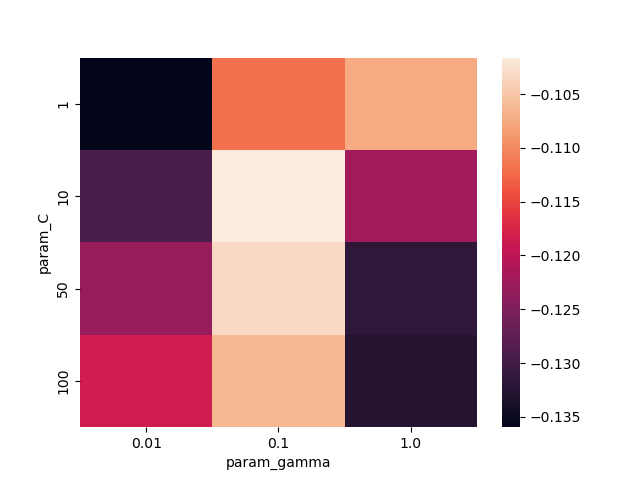

In [116]:
plt.figure()
pvt = pd.pivot_table(pd.DataFrame(reg.cv_results_),values='mean_test_score', index='param_C', columns='param_gamma')
ax = sns.heatmap(pvt)

In [148]:
pd.DataFrame.from_dict(reg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.115881,7.348554e-07,0.076818,0.007814,0.1,0.0005,0.01,rbf,"{'C': 0.1, 'epsilon': 0.0005, 'gamma': 0.01, '...",-0.281744,-0.277650,-0.291863,-0.278219,-0.282369,0.005701,1
1,0.115890,4.442846e-06,0.083000,0.002820,0.1,0.0005,0.1,rbf,"{'C': 0.1, 'epsilon': 0.0005, 'gamma': 0.1, 'k...",-0.281843,-0.278876,-0.293571,-0.277859,-0.283037,0.006256,5
2,0.127436,6.383242e-03,0.074217,0.006764,0.1,0.0005,1,rbf,"{'C': 0.1, 'epsilon': 0.0005, 'gamma': 1, 'ker...",-0.277222,-0.282158,-0.294791,-0.277696,-0.282967,0.007093,3
3,0.115880,1.849666e-06,0.076819,0.007813,1,0.0005,0.01,rbf,"{'C': 1, 'epsilon': 0.0005, 'gamma': 0.01, 'ke...",-0.282166,-0.278315,-0.292988,-0.278206,-0.282919,0.006028,2
4,0.123694,7.812560e-03,0.072909,0.006765,1,0.0005,0.1,rbf,"{'C': 1, 'epsilon': 0.0005, 'gamma': 0.1, 'ker...",-0.281387,-0.279753,-0.294486,-0.276333,-0.282990,0.006884,4
5,0.140977,5.879155e-03,0.069889,0.001527,1,0.0005,1,rbf,"{'C': 1, 'epsilon': 0.0005, 'gamma': 1, 'kerne...",-0.282292,-0.294219,-0.305888,-0.278312,-0.290178,0.010795,14
6,0.117959,2.144517e-03,0.081991,0.003456,10,0.0005,0.01,rbf,"{'C': 10, 'epsilon': 0.0005, 'gamma': 0.01, 'k...",-0.282773,-0.278944,-0.294316,-0.278233,-0.283567,0.006442,9
7,0.138669,5.565052e-03,0.079096,0.006402,10,0.0005,0.1,rbf,"{'C': 10, 'epsilon': 0.0005, 'gamma': 0.1, 'ke...",-0.283036,-0.283790,-0.298727,-0.275841,-0.285349,0.008324,10
8,0.208329,1.353220e-02,0.075191,0.006599,10,0.0005,1,rbf,"{'C': 10, 'epsilon': 0.0005, 'gamma': 1, 'kern...",-0.289973,-0.313951,-0.319495,-0.295124,-0.304635,0.012380,15
9,0.144198,6.598006e-03,0.073564,0.004558,50,0.0005,0.01,rbf,"{'C': 50, 'epsilon': 0.0005, 'gamma': 0.01, 'k...",-0.282559,-0.278696,-0.294910,-0.277924,-0.283522,0.006805,8


In [117]:
N=int(len(X_data)/4)
history4=[]
dz_val,dz_train=[],[]
start=time.time()
for i in range(4):
    Xs_train,y_train=Xs_data,y_data.values
    np.delete(Xs_train,np.s_[i*N:i*N+N],0)
    np.delete(y_train,np.s_[i*N:i*N+N],0)
    Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]
    ouscaler= StandardScaler()
    ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1)).ravel()
    ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1)).ravel()
    
    Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)
    
    svr=SVR(gamma=0.1,C=10,epsilon=0.0005)
    svr.fit(Xs_train, ys_train)
    
    pred_train=ouscaler.inverse_transform(svr.predict(Xs_train).reshape(-1,1)).ravel()
    pred_val=ouscaler.inverse_transform(svr.predict(Xs_val).reshape(-1,1)).ravel()
    dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
    dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
    print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
    print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
stop=time.time()
print(f"Training time: {stop - start}s")
print('train : \nstd :',np.mean([np.std(dz_train[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_train[i]) for i in range(4)])))
print('val   : \nstd :',np.mean([np.std(dz_val[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_val[i]) for i in range(4)])))

std train: 0.16272611973608067 
mean train: 0.01095107050199588
std val: 0.15794307780493083 
mean val: 0.012671179154525099
std train: 0.16272611973608067 
mean train: 0.01095107050199588
std val: 0.14487498032162346 
mean val: 0.015087897213508467
std train: 0.16272611973608067 
mean train: 0.01095107050199588
std val: 0.1917343093799035 
mean val: 0.0014506631559339067
std train: 0.16272611973608067 
mean train: 0.01095107050199588
std val: 0.15215077578386726 
mean val: 0.014496402007569924
Training time: 0.6938877105712891s
train : 
std : 0.16272611973608067 
mean : 0.01095107050199588
val   : 
std : 0.16167578582258124 
mean : 0.010926535382884349


In [40]:
print('train : \nstd :',np.mean([np.std(dz_train[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_train[i]) for i in range(4)])))
print('val   : \nstd :',np.mean([np.std(dz_val[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_val[i]) for i in range(4)])))

train : 
std : 0.13686764398275017 
mean : 0.011634319032973637
val   : 
std : 0.1364364018530602 
mean : 0.01159207855795891


### ANN

In [22]:
tf.keras.backend.set_floatx('float64')

In [1]:
def Model2(l2=1e-2):
    model = tf.keras.Sequential([
        tfl.Dense(20,'relu',input_shape=(10,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(12,'relu',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model

In [26]:
inscaler_S=StandardScaler()
Xs_data   =inscaler_S.fit_transform(X=X_data)

In [27]:
def score(ys_data,pred):
    return K.mean(K.abs((pred-ys_data)/(1+ys_data)))
def plot_his(history,n='n'):    #Plots the training and validation loss at every epoch
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    plt.figure()
    plt.plot(hisloss)
    plt.plot(hisval)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [28]:
X_data

,U,G,R,I,Z,J,H,K,W1,W2
117,22.820574,21.123146,19.713943,19.044422,18.705511,18.485289,18.088396,17.795053,17.884001,18.281000
1079,20.686909,20.329365,20.224869,20.235758,19.970482,19.610014,19.552105,19.438396,18.596001,18.195999
1452,21.234354,21.067202,20.676928,20.394091,20.338980,20.103697,19.886379,19.500803,19.188999,19.146000
403,21.051893,20.514565,20.136423,19.717728,19.597801,19.522404,19.530226,19.358416,18.868999,18.245001
1393,21.751276,20.680706,19.544489,19.110857,18.743494,18.475367,18.200159,17.891497,18.084999,18.084999
...,...,...,...,...,...,...,...,...,...,...
1227,20.096947,20.005444,19.739985,19.583921,19.555756,19.601942,19.119049,19.280861,18.816000,18.087999
1813,22.370806,22.520416,21.995825,22.140594,22.149782,20.989216,21.072842,20.606016,19.908991,19.783316
13,19.295452,18.983295,18.692270,18.295494,18.040789,18.085396,17.762287,17.471148,17.048000,16.997000
1622,20.544353,20.655293,20.281057,20.370070,20.496578,20.695564,20.242271,19.711861,19.357000,18.621000


In [28]:
#Use this block to load pre-trained models
Model23=[]
for i in range(3):
    #Model2=tf.lite.TFLiteConverter.from_keras_model('adamgama+13_'+str(i+1)+'/my_model')
    Model23.append(tf.keras.models.load_model('adamgama_13_'+str(i+1)+'/my_model',custom_objects={'score':score}))
model23=Model23

In [55]:
def DZ(pred,val):
    return (pred-val)/(1+val)

Our model is :
Train 6 ANNs, and take the average prediction of the best 3 models.
Then boost these predictions using an Xgboost model.

We now perform parameter tuning of Xgboost for the present problem.
Hyperparameters of ANNs have already been optimised in a different notebook.

In [183]:
N=int(len(Xs_data)/4)
nm,mm=7,7
hisvmean,histmean=np.zeros(4),np.zeros(4)
ms=[str(m) for m in range(1,nm+1)]
cs=['val','train','val_b','train_b']
keys=[c+m for m in ms for c in cs]
dz=dict(zip(keys, ([] for _ in keys)))
preds=dict(zip(keys, ([] for _ in dzkeys)))
XYkeys=['Xst','Xsv','yt','yv','t','v']
XY=dict(zip(XYkeys, ([] for _ in XYkeys)))
History=[[],[],[],[],[],[],[]]
Models=[]
lr=0.004
print('\t\t\t ANN \t\t\t\t\t boosted ANN')
#max_depths,lrs,n_ess,cols,subs,lambdas,gammas=[7,6,5,4],[0.6,0.3,0.15,0.07],[125,100,75,50],[1,0.85,0.7,0.5],[1,0.85,0.7,0.5],[0.75,1,1.25,1.5],[0,0.2,0.4,0.8]
#max_depths,lrs,n_ess,cols,subs,lambdas,gammas=[10,8,6,5,4,3],[2.4,1.2,0.6,0.3,0.15,0.075],[1000,500,250,125,60,30],[1,0.85,0.7,0.55,0.4,0.25],[1,0.85,0.7,0.55,0.4,0.25],[2,1,0.75,0.5,0.25,0],[2,1,0.75,0.5,0.25,0]
max_depths,lrs,cols,subs,lambdas,gammas=[80,50,30,20,12,8,5],0.15,0.85,0.85,0.75,0

scoresv,scorest=[[],[],[],[],[],[],[]],[[],[],[],[],[],[],[]]
def Loss(y_data,pred):
    return np.mean(abs((pred-y_data)/(1+y_data)))
for t in range(4):
    #history1,history2=[],[]
    #yval.append([]);ytrain.append([]),dz_val.append([]),dz_train.append([]),xsval.append([]),xstrain.append([])
    start=time.time()
    dztm,dzts,dzvm,dzvs,dztbm,dztbs,dzvbm,dzvbs=[],[],[],[],[],[],[],[]
    for p in range(4):
            print('\n')
            #dz_val_,dz_train_,y_val_,xs_val_,y_train_,xs_train_=[],[],[],[],[],[]
            Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
            del Xs_train[p*N:p*N+N]
            del y_train[p*N:p*N+N]
            Xs_val,y_val=Xs_data[p*N:p*N+N],y_data[p*N:p*N+N]
            ouscaler= MinMaxScaler()
            Xs_train,Xs_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(y_val),np.array(y_train)
            ys_train= ouscaler.fit_transform(y_train.reshape(-1,1))
            ys_val  = ouscaler.transform(y_val.reshape(-1,1))
            lv,lt=len(y_val),len(y_train)

            model23 = Model2(0)
            
            model=model23
            optimizer=tf.keras.optimizers.Adam(lr)
            model.compile(optimizer=optimizer,loss=score)
            History[i].append(model.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=2000,verbose=0))
            pred_train=ouscaler.inverse_transform(model.predict(Xs_train)).reshape(lt)
            pred_val  =ouscaler.inverse_transform(model.predict(Xs_val)).reshape(lv)
            print(Loss(pred_val,y_val),Loss(pred_train,y_train))
            for k in range(7):
                xgmodel = [xgb(max_depth=max_depths[k],learning_rate=lrs,reg_lambda=lambdas)]
                for i in range(1):
                    m=str(i+1)

                    xgmodel[i].fit(np.c_[Xs_train,pred_train],y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=[(np.c_[Xs_val,pred_val],y_val)],verbose=0)

                    pred_val_b  = xgmodel[i].predict(np.c_[Xs_val,pred_val])
                    pred_train_b= xgmodel[i].predict(np.c_[Xs_train,pred_train])

                    scoresv[i].append(Loss(pred_val_b,y_val))
                    scorest[i].append(Loss(pred_train_b,y_train))

			 ANN 					 boosted ANN


0.06581941 0.05040105501157328


0.084962554 0.05329524811217134


0.08654753 0.04183618350424003


0.07303324 0.03733531424095979


0.070875734 0.04562453620876733


0.085128784 0.05430048663771487


0.087160826 0.04322749062491038


0.07092523 0.04641113978586933


0.071345925 0.04958678563950658


0.062433314 0.04091547030749336


0.09286871 0.04910905796548617


0.08013099 0.04158538115152279


0.07590505 0.05088099863575849


0.061417203 0.04135328994307497


0.07368628 0.043066535599514996


0.080877274 0.042887777324728225


In [109]:
scoresv,scorest

([[0.069620095,
   0.0729643,
   0.08298722,
   0.07031636,
   0.10082365,
   0.06558832,
   0.12126233,
   0.087547764,
   0.06781864,
   0.07950357,
   0.07547954,
   0.07602048,
   0.076875605,
   0.07287476,
   0.08307574,
   0.077615306],
  [0.07335759,
   0.07798411,
   0.08405582,
   0.07017815,
   0.10082365,
   0.06558832,
   0.12126233,
   0.087547764,
   0.08134776,
   0.076889135,
   0.08329242,
   0.07156867,
   0.084109075,
   0.075525194,
   0.087751314,
   0.075229816],
  [0.06716397,
   0.07366911,
   0.08324196,
   0.06973272,
   0.10082365,
   0.06558832,
   0.12126233,
   0.087547764,
   0.06974715,
   0.0792616,
   0.07830625,
   0.07292436,
   0.07168457,
   0.07202055,
   0.084430255,
   0.075068705],
  [0.06716397,
   0.07366911,
   0.08324196,
   0.06973272,
   0.07137163,
   0.07281432,
   0.091528855,
   0.08757355,
   0.069438666,
   0.080318026,
   0.077903025,
   0.07304034,
   0.08790686,
   0.08499172,
   0.08975849,
   0.08361123],
  [0.06716397,
   0.0

In [139]:
Lv,Lt=Loss(pred_val,y_val),Loss(pred_train,y_train)

In [127]:
Lv1,Lt1=0.0778677, 0.04602874208250848

In [184]:
lossv,losst={},{}
for j,var in enumerate(['max_depths']):
    lossv[var]=[]
    losst[var]=[]
    for i in range(7):
        lossv[var].append(np.mean(scoresv[j][i::7]))
        losst[var].append(np.mean(scorest[j][i::7]))

In [134]:
lossv1,losst1={},{}
for j,var in enumerate(['max_depths','lrs','n_ess','cols','subs','lambdas','gammas']):
    lossv1[var]=[]
    losst1[var]=[]
    for i in range(4):
        lossv1[var].append(np.mean(scoresv1[j][4*i:4*(i+1)])-Lv1)
        losst1[var].append(np.mean(scorest1[j][4*i:4*(i+1)])-Lt1)

In [145]:
lossv,losst

({'max_depths': [0.0055551305,
   0.005852379,
   0.007135935,
   0.0064625517,
   0.010360539,
   0.011097401],
  'lrs': [0.26868543,
   0.015233584,
   0.0072394684,
   0.007135935,
   0.007072009,
   0.0085919425],
  'n_ess': [0.007135935,
   0.007135935,
   0.007135935,
   0.007135935,
   0.0071517453,
   0.007157184],
  'cols': [0.007135935,
   0.0051696524,
   0.008741774,
   0.008649729,
   0.019226395,
   0.033828013],
  'subs': [0.007135935,
   0.005443074,
   0.007601753,
   0.0075218603,
   0.008764721,
   0.00954441],
  'lambdas': [0.009580664,
   0.007135935,
   0.0055703893,
   0.006314166,
   0.007882267,
   0.00809785],
  'gammas': [0.014171831,
   0.00974492,
   0.008739971,
   0.008606054,
   0.0073392913,
   0.007135935]},
 {'max_depths': [-0.028915834733459045,
   -0.0187389642240362,
   -0.008872668489806078,
   -0.005879659861295981,
   0.004093964895019293,
   0.00906820058160468],
  'lrs': [0.2795983075470426,
   -0.004823066377500768,
   -0.0072508513562137,
  

<IPython.core.display.Javascript object>


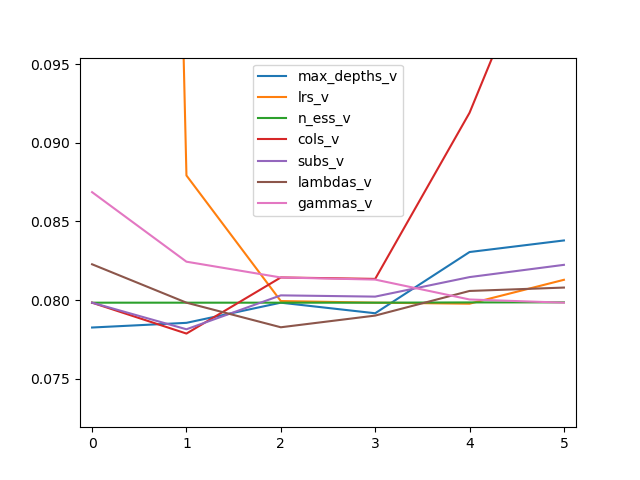

In [151]:
#Plot the validation loss for different values of each parameter
plt.figure()
for var in ['max_depths','lrs','n_ess','cols','subs','lambdas','gammas']:
    plt.plot(lossv[var],label=var+'_v')
    #plt.plot(losst[var],label=var+'_t')
plt.legend()

<IPython.core.display.Javascript object>


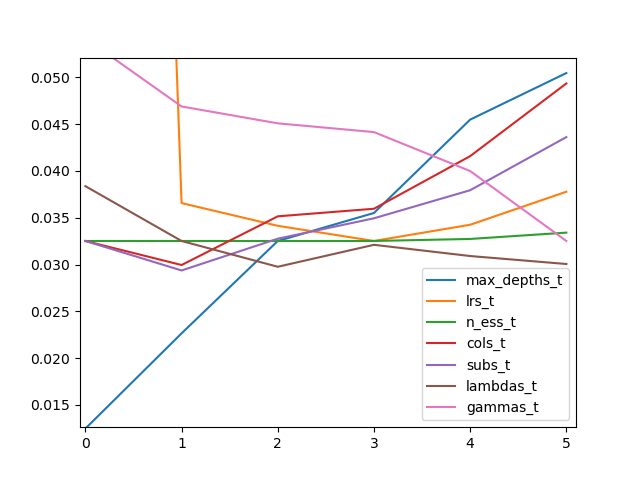

In [153]:
#Plot the training loss for different values of each parameter
plt.figure()
for var in ['max_depths','lrs','n_ess','cols','subs','lambdas','gammas']:
    #plt.plot(lossv[var],label=var+'_v')
    plt.plot(losst[var],label=var+'_t')
plt.legend()

In [171]:
lossv['max_depths']

[0.07631309]

In [187]:
N=int(len(Xs_data)/4)
nm,mm=6,3
hisvmean,histmean=np.zeros(4),np.zeros(4)
ms=[str(m) for m in range(1,nm+1)]
cs=['val','train','val_b','train_b']
keys=[c+m for m in ms for c in cs]
dz=dict(zip(keys, ([] for _ in keys)))
preds=dict(zip(keys, ([] for _ in dzkeys)))
XYkeys=['Xst','Xsv','yt','yv','t','v']
XY=dict(zip(XYkeys, ([] for _ in XYkeys)))
History=[[],[],[],[],[],[]]
Models=[]
Losses=[[],[],[],[],[],[]]
lr=0.004
print('\t\t\t ANN \t\t\t\t\t boosted ANN')
max_depths,lrs,cols,subs,lambdas,gammas=[80,50,30,20,12,8,5],0.15,0.85,0.85,0.75,0
def Loss(y_data,pred):
    return np.mean(abs((pred-y_data)/(1+y_data)))
for k in range(1):
    #history1,history2=[],[]
    #yval.append([]);ytrain.append([]),dz_val.append([]),dz_train.append([]),xsval.append([]),xstrain.append([])
    start=time.time()
    dztm,dzts,dzvm,dzvs,dztbm,dztbs,dzvbm,dzvbs=[],[],[],[],[],[],[],[]
    for p in range(4):
            print('\n')
            #dz_val_,dz_train_,y_val_,xs_val_,y_train_,xs_train_=[],[],[],[],[],[]
            Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
            del Xs_train[p*N:p*N+N]
            del y_train[p*N:p*N+N]
            Xs_val,y_val=Xs_data[p*N:p*N+N],y_data[p*N:p*N+N]
            ouscaler= MinMaxScaler()
            Xs_train,Xs_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(y_val),np.array(y_train)
            ys_train= ouscaler.fit_transform(y_train.reshape(-1,1))
            ys_val  = ouscaler.transform(y_val.reshape(-1,1))
            lv,lt=len(y_val),len(y_train)

            model23 = [Model2(0),Model2(0),Model2(0),Model2(0),Model2(0),Model2(0)]
            xgmodel = [xgb(max_depth=9,learning_rate=0.15,reg_lambda=0.75,colsample_bytree=0.85,subsample=0.85) for _ in range(6)]
            
            for i in range(nm):
                m=str(i+1)

                model=model23[i]
                optimizer=tf.keras.optimizers.Adam(lr)
                model.compile(optimizer=optimizer,loss=score)
                History[i].append(model.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=2000,verbose=0))
                
                pred_train=ouscaler.inverse_transform(model.predict(Xs_train)).reshape(lt)
                pred_val  =ouscaler.inverse_transform(model.predict(Xs_val)).reshape(lv)
                
                xgmodel[i].fit(np.c_[Xs_train,pred_train],y_train)
                
                pred_val_b  = xgmodel[i].predict(np.c_[Xs_val,pred_val])
                pred_train_b= xgmodel[i].predict(np.c_[Xs_train,pred_train])
                
                dz['val'+m].append(DZ(pred_val,y_val)) ; dz['train'+m].append(DZ(pred_train,y_train))
                dz['val_b'+m].append(DZ(pred_val_b,y_val)) ; dz['train_b'+m].append(DZ(pred_train_b,y_train))
                
                print(m,'train \tstd :',f"{np.std(dz['train'+m][-1]):.3E}",'\tmean :',f"{np.mean(dz['train'+m][-1]):.3E}",
                      '\tstd :',f"{np.std(dz['train_b'+m][-1]):.3E}",'\tmean :',f"{np.mean(dz['train_b'+m][-1]):.3E}")
                print(m,'val \t\tstd :',f"{np.std(dz['val'+m][-1]):.3E}",'\tmean :',f"{np.mean(dz['val'+m][-1]):.3E}",
                      '\tstd :',f"{np.std(dz['val_b'+m][-1]):.3E}",'\tmean :',f"{np.mean(dz['val_b'+m][-1]):.3E}")
                
                Models.append(model)
                Losses[i].append(Loss(pred_val_b,y_val))
            m=np.argsort([Losses[j][-1] for j in range(nm)])+1
            hisvmean[p]=np.mean([History[o-1][-1].history['val_loss'][-1] for o in m[:3]])
            histmean[p]=np.mean([History[o-1][-1].history['loss'][-1] for o in m[:3]])

            dzt,dzv  =np.mean([dz['train'+str(m[i])][-1] for i in range(mm)],axis=0),  np.mean([dz['val'+str(m[i])][-1] for i in range(mm)],axis=0)
            dzbt,dzbv=np.mean([dz['train_b'+str(m[i])][-1] for i in range(mm)],axis=0),np.mean([dz['val_b'+str(m[i])][-1] for i in range(mm)],axis=0)

            dztm.append(np.mean(dzt));dzts.append(np.std(dzt));dzvm.append(np.mean(dzv)),dzvs.append(np.std(dzv))
            dztbm.append(np.mean(dzbt));dztbs.append(np.std(dzbt));dzvbm.append(np.mean(dzbv)),dzvbs.append(np.std(dzbv))
            print('X train \tstd :',f"{dzts[-1]:.3E}",'\tmean :',f"{dztm[-1]:.3E}",'\tstd :',f"{dztbs[-1]:.3E}",'\tmean :',f"{dztbm[-1]:.3E}")
            print('X val \t\tstd :',f"{dzvs[-1]:.3E}",'\tmean :',f"{dzvm[-1]:.3E}",'\tstd :',f"{dzvbs[-1]:.3E}",'\tmean :',f"{dzvbm[-1]:.3E}")     
    stop=time.time()
    print(f"\nTraining time: {stop - start}s")
    trainstd,trainmean,valstd,valmean=np.mean(dzts[-4:]),np.mean(np.abs(dztm[-4:])),np.mean(dzvs[-4:]),np.mean(np.abs(dzvm[-4]))
    trainstdb,trainmeanb,valstdb,valmeanb=np.mean(dztbs[-4:]),np.mean(np.abs(dztbm[-4:])),np.mean(dzvbs[-4:]),np.mean(np.abs(dzvbm[-4]))
    print('XX train \tstd :',f"{trainstd:.3E}",'\tmean :',f"{trainmean:.3E}",'\tstd :',f"{trainstdb:.3E}",'\tmean :',f"{trainmeanb:.3E}")
    print('XX val \t\tstd :',f"{valstd:.3E}",'\tmean :',f"{valmean:.3E}",'\tstd :',f"{valstdb:.3E}",'\tmean :',f"{valmeanb:.3E}")
    trainloss=np.mean(histmean)
    valloss=np.mean(hisvmean)
    print(' trainloss-',f"{trainloss:.3E}",'\tvalloss-',f"{valloss:.3E}")
    #pickle.dump(return_his(history4), open(str(l2)+'_11_10_2.pkl', 'wb'))
#model4.save('model_1_17_10/my_model')'''

			 ANN 					 boosted ANN


1 train 	std : 7.838E-02 	mean : 2.508E-03 	std : 4.041E-03 	mean : 1.718E-04
1 val 		std : 1.860E-01 	mean : 1.648E-02 	std : 1.935E-01 	mean : 2.113E-02
2 train 	std : 7.596E-02 	mean : -1.660E-02 	std : 4.786E-03 	mean : 2.499E-04
2 val 		std : 1.797E-01 	mean : -5.619E-05 	std : 1.851E-01 	mean : 2.354E-02
3 train 	std : 7.827E-02 	mean : -1.805E-02 	std : 4.844E-03 	mean : 2.184E-04
3 val 		std : 1.902E-01 	mean : -5.173E-04 	std : 1.842E-01 	mean : 2.235E-02
4 train 	std : 7.437E-02 	mean : -3.132E-03 	std : 3.819E-03 	mean : 1.511E-04
4 val 		std : 2.093E-01 	mean : 1.389E-02 	std : 2.054E-01 	mean : 2.701E-02
5 train 	std : 8.203E-02 	mean : -1.935E-02 	std : 4.658E-03 	mean : 2.291E-04
5 val 		std : 1.568E-01 	mean : -9.214E-03 	std : 1.687E-01 	mean : 2.337E-02
6 train 	std : 8.682E-02 	mean : -3.701E-03 	std : 4.733E-03 	mean : 2.396E-04
6 val 		std : 1.157E-01 	mean : 1.318E-03 	std : 1.205E-01 	mean : 1.545E-02
X train 	std : 6.848E-02 	mean : -